In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
import torch.nn.functional as functional
import shutil
import matplotlib.pyplot as plt

custom_transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5 ), (0.5))],
    )

# clarity_transform = torchvision.transforms.Compose(
#     [torchvision.transforms.ToTensor(),
#      torchvision.transforms.Normalize(0.5, 0.5),
#  torchvision.transforms.RandomChoice([torchvision.transforms.ColorJitter(contrast=2),torchvision.transforms.ColorJitter(contrast=0.5)])
#  ]
# )
classes = ('-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'empty')

class Network(nn.Module):
    def __init__(self):
        self.output_size = 12
        
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(400, 120)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, self.output_size)
        
    def forward(self, x):
        x = self.pool(functional.relu(self.conv1(x)))
        x = self.pool(functional.relu(self.conv2(x)))
        x = x.view(-1, 400)
        x = functional.relu(self.fc(x))
        x = functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

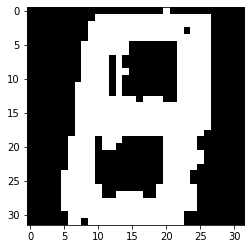

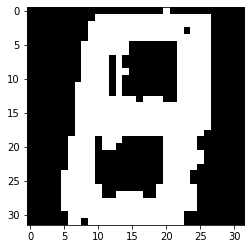

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


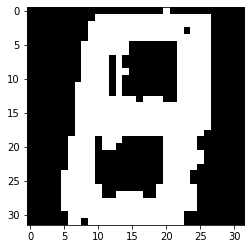

In [14]:
testimg = cv2.imread("./00010transform/52.png")
plt.imshow(testimg)
plt.show()
testimg = torchvision.transforms.ToTensor()(testimg)
plt.imshow(testimg.permute(1,2, 0))
plt.show()
testimg = torchvision.transforms.Normalize((0.5 ), (0.5))(testimg)
plt.imshow(testimg.permute(1,2, 0))
plt.show()

In [2]:
def openVideo(videoname):
    video = cv2.VideoCapture("./" + videoname)
    #check if the video exists
    if not video.isOpened():
        raise Exception("Video cannot be opened.")
    return video
        

def readOneVideo(videoname, dstpath):
    os.makedirs(dstpath)
    video = openVideo(videoname)
    rval = True
    frame_cnt = 0
    frameid = 1
    while rval:
        rval, frame = video.read()
        frame_cnt += 1
        if rval == False:
            break
        if frame_cnt % 5 != 0: # 0.02s 一张，这里每5张取一张，就是每0.1s取一张
            continue
        cv2.imwrite(dstpath+str(frameid/10)+".png", frame)
        frameid += 1
        

def pad_image(im, height, width): #(height width) are the target 
    im = Image.fromarray(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))  # 把图片从cv2格式转换成Image
    w, h = im.size  

    if w>=h*width/height:
        h1 = int(h*width/w)
        im = im.resize((width, h1),  Image.BILINEAR)
        im_new = Image.new(mode='RGB', size=(width, height), color=0)
        im_new.paste(im, ( 0, (height-h1)//2 ) )
    else:
        w1 = int(w*height/h)
        im = im.resize((w1, height),  Image.BILINEAR)
        im_new = Image.new(mode='RGB', size=(width, height), color=0)
        im_new.paste(im, ( (width-w1)//2, 0 ) )

    im_new = cv2.cvtColor(np.asarray(im_new), cv2.COLOR_RGB2BGR)  # 将Image格式的图片转成np进而转换成cv2格式    
    return im_new

def processImage(img, templatepath, type):
    ned = cv2.imread(templatepath)
    result = cv2.matchTemplate(img, ned, cv2.TM_CCOEFF_NORMED)
    
    _, _, _, max_loc = cv2.minMaxLoc(result)
    test_img = img # test_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 

    if type == "R":
        # _, test_img = cv2.threshold(test_img, 150, 255, cv2.THRESH_BINARY)
        sample1 = test_img[max_loc[1] : max_loc[1]+26, max_loc[0]-50 : max_loc[0]-24] 
        sample2 = test_img[max_loc[1] : max_loc[1]+26, max_loc[0]-25 : max_loc[0]+1]
        negsample = test_img[max_loc[1] : max_loc[1]+26, max_loc[0]+23 : max_loc[0]+49]
        sample3 = test_img[max_loc[1]-1 : max_loc[1]+25, max_loc[0]+48 : max_loc[0]+74]
        
    elif type == "Tm":
        # _, test_img = cv2.threshold(test_img, 60, 255, cv2.THRESH_BINARY)
        sample1 = test_img[max_loc[1]+7 : max_loc[1]+40, max_loc[0]-87 : max_loc[0]-64] #之前是+9，+42，-84，-62
        sample2 = test_img[max_loc[1]+7 : max_loc[1]+40, max_loc[0]-60 : max_loc[0]-37] # 之前是+7，+40，-57，-34
        negsample = test_img #useless, since temperature cannot be negative
        sample3 = test_img[max_loc[1]+7 : max_loc[1]+40, max_loc[0]-30 : max_loc[0]-7] #之前是+8，+41，-28，-5
    
    elif type == "T":
        # print("max_loc=",max_loc)
        # sample = test_img[max_loc[1]-20: max_loc[1]+40, max_loc[0]-140:, ::-1] #just for debug
        # _, test_img = cv2.threshold(test_img, 150, 255, cv2.THRESH_BINARY)
        sample1 = test_img[max_loc[1]+2 : max_loc[1]+32, max_loc[0]-74 : max_loc[0]-44]
        sample2 = test_img[max_loc[1]+2 : max_loc[1]+32, max_loc[0]-38 : max_loc[0]-8]
        negsample = test_img[max_loc[1] : max_loc[1]+30, max_loc[0]+33 : max_loc[0]+63]
        sample3 = test_img[max_loc[1] : max_loc[1]+30, max_loc[0]+69 : max_loc[0]+99]

    elif type == "I":
        # sample = test_img[max_loc[1]-20: max_loc[1]+40, max_loc[0]-140:, ::-1] #just for debug
        # _, test_img = cv2.threshold(test_img, 150, 255, cv2.THRESH_BINARY)
        sample1 = test_img[max_loc[1]+4 : max_loc[1]+34, max_loc[0]-74 : max_loc[0]-44] # 之前是+3，+33，-74，-44
        sample2 = test_img[max_loc[1]+3 : max_loc[1]+33, max_loc[0]-38 : max_loc[0]-8] # 之前是+2，+32，-38，-8
        negsample = test_img[max_loc[1]+3 : max_loc[1]+33, max_loc[0]+35 : max_loc[0]+65]
        sample3 = test_img[max_loc[1] : max_loc[1]+30, max_loc[0]+73 : max_loc[0]+103] # 之前是-1，+29，+73，+103
 
    sample1 = pad_image(sample1, 32, 32)
    sample2 = pad_image(sample2, 32, 32)
    negsample = pad_image(negsample, 32, 32)
    sample3 = pad_image(sample3, 32, 32)
    
    # plt.imshow(sample1)
    # plt.show()
    # plt.imshow(sample2)
    # plt.show()
    # plt.imshow(negsample)
    # plt.show()
    # plt.imshow(sample3)
    # plt.show()

    return sample1, sample2, negsample, sample3

def cutImages(srcdirname, dstdirname):
    # Cut images in this folder into single numbers.
    #If you want to use this block you need to create this fold and put images into it
    os.makedirs(dstdirname)
    img_cnt = 0
    for imgname in os.listdir(srcdirname):
        image = cv2.imread(srcdirname+imgname)
        width, length, _ = np.shape(image)
        first, second, neg, third = processImage(image[0:width//2, 0:length//3], "./E1.png", "R") #左上角的表
        cv2.imwrite(dstdirname+"{i}.png".format(i = img_cnt),first)
        cv2.imwrite(dstdirname+"{i}.png".format(i = img_cnt+1),second)
        cv2.imwrite(dstdirname+"{i}.png".format(i = img_cnt+2),neg)
        cv2.imwrite(dstdirname+"{i}.png".format(i = img_cnt+3),third)

        first, second, _, third = processImage(image[2*width//5:(width-1), 0:length//2], "./oC.png", "Tm") #左下角的表
        cv2.imwrite(dstdirname+"{i}.png".format(i = img_cnt+4),first)
        cv2.imwrite(dstdirname+"{i}.png".format(i = img_cnt+5),second)
        cv2.imwrite(dstdirname+"{i}.png".format(i = img_cnt+6),third)

        first, second, neg, third = processImage(image[0:width//2, 2*length//5:4*length//5], "./E2.png", "T") #低真空表
        cv2.imwrite(dstdirname+"{i}.png".format(i = img_cnt+7),first)
        cv2.imwrite(dstdirname+"{i}.png".format(i = img_cnt+8),second)
        cv2.imwrite(dstdirname+"{i}.png".format(i = img_cnt+9),neg)
        cv2.imwrite(dstdirname+"{i}.png".format(i = img_cnt+10),third)

        first, second, neg, third = processImage(image[0:width//2, 7*length//10:], "./E3.png", "I") #高真空表
        cv2.imwrite(dstdirname+"{i}.png".format(i = img_cnt+11),first)
        cv2.imwrite(dstdirname+"{i}.png".format(i = img_cnt+12),second)
        cv2.imwrite(dstdirname+"{i}.png".format(i = img_cnt+13),neg)
        cv2.imwrite(dstdirname+"{i}.png".format(i = img_cnt+14),third)

        img_cnt += 15

def loadNet(netpath):
    net = Network()
    net.load_state_dict(torch.load(netpath))
    return net

def check(image, net):#test one image
    test_path1 = './1/'
    test_path = './1/1/'
    first_path = './1/1/image.png'
    if os.path.isfile(first_path):
        os.remove(first_path)
    if os.path.exists(test_path):
        os.removedirs(test_path)
            
    os.makedirs(test_path)
    image = cv2.resize(image, (32, 32))
    cv2.imwrite(first_path, image)
    real_test = ImageFolder(root=test_path1, transform=custom_transform)
    real_testloader = torch.utils.data.DataLoader(
        real_test,
        batch_size = 1,
        shuffle = False
        )
    dataiter = iter(real_testloader)
    images, labels = dataiter.next()
    outputs = net(images)#can't understand why!
    sm = nn.Softmax(dim=1)      
    sm_outputs = sm(outputs)
    _, index = torch.max(sm_outputs, dim=1)
    first = eval(classes[index[0]])
    result = first
    os.remove(first_path)
    os.removedirs(test_path)
    return result

def classifyImg(srcdirname, dstdirname, net):
    for imgpath in os.listdir(srcdirname):
        img = cv2.imread(srcdirname+imgpath)
        resnum = check(img, net)
        shutil.move(srcdirname+imgpath, dstdirname+str(resnum))

def addToDataset(srcdirname, dstdirname):
    # if it is possible to have the same name, rename the image before
    # adding to the dataset
    # rename to avoid the same name
    for dir in os.listdir(srcdirname):
        for imgname in os.listdir(srcdirname+dir):
            os.rename(srcdirname+dir+"/"+imgname, srcdirname+dir+"/"+"new-"+imgname)
    # move to dstdir
    for dir in os.listdir(srcdirname):
        for imgname in os.listdir(srcdirname+dir):
            shutil.move(srcdirname+dir+"/"+imgname, dstdirname+dir+"/"+imgname)
    # rename to avoid the same name
    for dir in os.listdir(dstdirname):
        for i, imgname in enumerate(os.listdir(dstdirname+dir), 1):
            os.rename(dstdirname+dir+"/"+imgname, dstdirname+dir+"/"+str(i)+"-newnew.png")
    # then rename again
    for dir in os.listdir(dstdirname):
        for i, imgname in enumerate(os.listdir(dstdirname+dir), 1):
            os.rename(dstdirname+dir+"/"+imgname, dstdirname+dir+"/"+str(i)+".png")

In [ ]:
# first step: snapshot video
# note: it will save to disk
readOneVideo("00010.MTS", "./00010raw/")

In [4]:
# second step: cut each snapshot into 15 numbers(or negative sign)
# note: it will save to disk
cutImages(srcdirname="./00010raw/", dstdirname="./00010cut/")

In [5]:
def transformImage(srcdirname, dstdirname):
    os.mkdir(dstdirname)
    for img in os.listdir(srcdirname):
        test_img = cv2.imread(srcdirname+img)
        test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
        _, test_img = cv2.threshold(test_img, 70, 255, cv2.THRESH_BINARY)
        cv2.imwrite(dstdirname+img, test_img)
transformImage(srcdirname="./00010cut/", dstdirname="./00010transform/")

In [ ]:
# third step: load old network, classify images roughly
# note: it will move the image from srcpath to dstpath. Classfication may be wrong, so
# you have to check and remove some images to correct directory if neccessary
net = loadNet("./result_bsize=24, epoch=100.pth")
classifyImg(srcdirname="./00011cut/", dstdirname="./00011trainset_classified/", net=net)


In [ ]:
# fourth step: after your checking and reclassification, you may want to shrink
# the size of some class of images. For example, if "7" class has 100 images, but
# "8" class has 10 images, you may want to shrink "7" class to 10 images to keep
# number of images of each class balanced.

# Shrink testset or trainset. For example, shrinksize=3 means newsize=oldsize/3 
def shrinkDataset(dirname, shrinksize):
    path = "./" + dirname + "/"
    # for list in os.listdir(input):
    #     list = list + '/'
    for i, img in enumerate(os.listdir(path)):
        i += 1
        if(i % shrinksize != 0):
            os.remove(path+img)
# shrinkDataset(dirname = "trainset/3", shrinksize = 2)

In [ ]:
# fifth step: after your checking, you could call this function to add those image to
# your original dataset
# addToDataset(srcdirname="./00011trainset_classified/", dstdirname="./trainset/")

In [15]:
def countFileNum(dirname):
    dirname = "./" + dirname + "/"
    for dir in os.listdir(dirname):
        print(dir + ": " + str(len(os.listdir(dirname+dir))))

countFileNum("00011trainset_classified")
countFileNum("trainset")

0: 0
1: 0
2: 0
3: 0
4: 0
5: 0
6: 0
7: 0
8: 0
9: 0
-: 172
0: 277
1: 230
2: 295
3: 256
4: 317
5: 330
6: 335
7: 244
8: 260
9: 218
empty: 86
